In [1]:
import os
import itertools
import time
import random
import numpy as np
import pandas as pd
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import LSTM, Bidirectional, Dense, Masking
from tensorflow.keras.layers import Input, Permute
from tensorflow.keras.models import Model
from keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam


In [2]:
import tensorflow as tf

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    print("GPU device not found. Đảm bảo bạn đã chọn runtime GPU.")
else:
    print(f"Found GPU at: {device_name}")

Num GPUs Available:  1
Found GPU at: /device:GPU:0


In [3]:
def flattern(p):
    pred_y_matrix = [[] for _ in range(len(p[0]))]
    for pp in p:
        a = pp.tolist()
        for m in range(len(a)):
            pred_y_matrix[m] += a[m]
    return pred_y_matrix


def interpolate(data, mask=-1):
    temp = [list(dd) for dd in data]
    d = []
    for i in range(len(temp)):
        # biến mask thành NaN để interpolate
        arr = [np.nan if x == mask else x for x in temp[i]]
        df = pd.Series(arr).interpolate(method='linear').fillna(method='bfill').fillna(method='ffill')
        d.append(df.tolist())
    return d


def data_split(dat, train_hour, test_hour, predict_position, stride):
    x, y = [], []
    period = train_hour + predict_position + test_hour
    i = 0
    length = len(dat[0])
    while i + period <= length:
        x_temp, y_temp = [], []
        for series in dat:
            x_temp.append(series[i : i + train_hour])
            y_temp.append(series[
                i + train_hour + predict_position :
                i + train_hour + predict_position + test_hour
            ])
        x.append(x_temp)
        y.append(y_temp)
        i += stride
    return np.array(x), np.array(y)


def split_train(int_dat, norm_dat, T1, T2, T3, stride, start, end, data_name=None):
    length = len(int_dat[0])
    s = int(length * start)
    e = int(length * end)

    # X train: normalize toàn bộ (loại đoạn test s:e), X test: lấy interpolate trên bản int_dat
    Train = [serie[:s] + serie[e:] for serie in norm_dat]
    Test = [serie[s:e] for serie in int_dat]

    print(f'Training series length: {len(Train[0])}; Test series length: {len(Test[0])}')
    train_x, train_y = data_split(Train, T1, T2, T3, stride)
    test_x, test_y = data_split(Test,  T1, T2, T3, stride)
    return train_x, train_y, test_x, test_y


def data_normalize(Dat, mask=-1):
    new_dat = []
    scaling = []
    for d in Dat:
        valid = [v for v in d if v != mask]
        mn = np.min(valid) if valid else 0
        mx = np.max(valid) if valid else 1
        normed = [(v - mn) / (mx - mn) if v != mask and mx != mn else v
                  for v in d]
        new_dat.append(normed)
        scaling.append((mn, mx))
    return new_dat, scaling


In [4]:
def load_and_align_data(sensor_files, variables, mask=-1):
    data = []
    variable_names = []
    time_index = None

    # Tìm giao time_index
    for _, fp in sensor_files.items():
        df = pd.read_csv(fp, parse_dates=['datetime'], index_col='datetime')
        df.fillna(mask, inplace=True)
        time_index = df.index if time_index is None else time_index.intersection(df.index)

    # Đọc lại từng sensor theo time_index chung
    for name, fp in sensor_files.items():
        df = pd.read_csv(fp, parse_dates=['datetime'], index_col='datetime')
        df.fillna(mask, inplace=True)
        for var in variables:
            if var in df:
                series = df.loc[time_index, var].tolist()
                data.append(series)
                variable_names.append(f"{name}_{var}")

    return data, variable_names, time_index

def stacked_LSTM(X, Y, lstm_units=[32,], lr=1e-5):
    timesteps, n_features = X.shape[1], X.shape[2]
    out_dim = Y.shape[2]

    model = Sequential([
        Masking(mask_value=-1., input_shape=(timesteps, n_features)),
        Bidirectional(LSTM(lstm_units[0], activation='relu', return_sequences=True)),
        # nếu muốn thêm layer nữa, uncomment dưới
        # Bidirectional(LSTM(lstm_units[1], activation='relu', return_sequences=True)),
        Dense(out_dim)
    ])
    model.compile(
        loss='mean_absolute_error',
        optimizer=Adam(learning_rate=lr)
    )
    early_stop = EarlyStopping(
        monitor='val_loss', patience=10, restore_best_weights=True
    )

    # ép GPU nếu có
    import tensorflow as tf
    with tf.device('/GPU:0'):
        hist = model.fit(
            X, Y,
            epochs=50,
            batch_size=10,
            validation_split=0.2,
            callbacks=[early_stop],
            verbose=1
        )

    model.summary()
    return model, hist


def SP_Learner(data, train_time, predict_time, predict_position, stride, start, end, data_name):
    # chuẩn hóa và interpolate
    norm_dat, scaling = data_normalize(data)
    interp_dat = interpolate(norm_dat, mask=-1)

    # tạo train/test sets
    train_x, train_y, test_x, test_y = split_train(
        interp_dat, norm_dat,
        train_time, predict_time, predict_position,
        stride, start, end, data_name
    )

    # train model
    model, hist = stacked_LSTM(train_x, train_y)
    pred_y = model.predict(test_x, verbose=1)

    return pred_y, test_y, model, scaling

In [5]:
def evaluate_model(pred_y, test_y, variable_names, scaling_params, time_index, start):
    results = {}
    for i, var in enumerate(variable_names):
        mn, mx = scaling_params[i]
        # reshape về 1d để evaluate
        pred_flat = pred_y[:, i, 0].ravel() * (mx - mn) + mn
        true_flat = test_y[:,i,0].ravel() * (mx - mn) + mn

        # xác định time axis
        s = int(len(time_index) * start)
        dates = pd.date_range(
            start=time_index[s],
            periods=len(pred_flat),
            freq=time_index[1] - time_index[0]
        )

        # tìm shift tối ưu
        metrics = []
        for sh in range(-20,1):
            sp = np.roll(pred_flat, sh)
            if sh<0: sp[sh:] = sp[sh-1]
            mae  = mean_absolute_error(true_flat, sp)
            rmse = np.sqrt(mean_squared_error(true_flat, sp))
            r2   = r2_score(true_flat, sp)
            mape = mean_absolute_percentage_error(true_flat+1e-10, sp+1e-10)*100
            metrics.append((sh, mae, rmse, r2, mape))
        best = min(metrics, key=lambda x: x[1])
        sh, mae0, rmse0, r20, mape0 = best

        plt.figure(figsize=(12,5))
        plt.plot(dates, np.roll(pred_flat, sh), label=f'Pred (shift {sh})')
        plt.plot(dates, true_flat, label='True')
        plt.legend(); plt.title(var); plt.tight_layout(); plt.show()

        print(f"\n{var} -> MAE:{mae0:.4f}, RMSE:{rmse0:.4f}, R²:{r20:.4f}, MAPE:{mape0:.2f}% (shift={sh})")

        results[var] = {
            'MAE': mae0, 'RMSE': rmse0, 'R2': r20, 'MAPE': mape0, 'shift': sh
        }
    return results

Predict 4 using 1,2,3

In [6]:
def load_and_align_data(sensor_files, variables, mask=-1):
    # --- như trước ---
    data, variable_names, time_index = [], [], None
    for _, fp in sensor_files.items():
        df = pd.read_csv(fp, parse_dates=['datetime'], index_col='datetime')
        df.fillna(mask, inplace=True)
        time_index = df.index if time_index is None else time_index.intersection(df.index)
    for name, fp in sensor_files.items():
        df = pd.read_csv(fp, parse_dates=['datetime'], index_col='datetime')
        df.fillna(mask, inplace=True)
        for var in variables:
            if var in df.columns:
                data.append(df.loc[time_index, var].tolist())
                variable_names.append(f"{name}_{var}")
    return data, variable_names, time_index

def build_LSTM(timesteps, n_features, out_dim, lstm_units=[64,32], lr=1e-4):
    m = Sequential([
        Masking(mask_value=-1., input_shape=(timesteps, n_features)),
        Bidirectional(LSTM(lstm_units[0], activation='relu', return_sequences=True)),
        Bidirectional(LSTM(lstm_units[1], activation='relu', return_sequences=True)),
        Dense(out_dim)
    ])
    m.compile(loss='mean_absolute_error', optimizer=Adam(learning_rate=lr))
    return m


In [7]:
def SP_Learner_3to1(data_in, data_out, train_time, test_time, pred_pos, stride, start, end):
    norm_in,  _        = data_normalize(data_in)
    norm_out, scale_out= data_normalize(data_out)
    interp_in  = interpolate(norm_in,  mask=-1)
    interp_out = interpolate(norm_out, mask=-1)

    # Split windows cho X từ Sensor 1–3
    train_x, _, val_x, _ = split_train(
        interp_in, norm_in,
        train_time, test_time, pred_pos, stride, start, end
    )
    # train_x.shape = (N_train, train_time, 3)

    # Split windows cho Y từ Sensor 4
    _, train_y, _, val_y = split_train(
        interp_out, norm_out,
        train_time, test_time, pred_pos, stride, start, end
    )
    # train_y.shape = (N_train, test_time, 1)

    model = build_LSTM(
        timesteps = train_x.shape[1],
        n_features= train_x.shape[2],
        out_dim   = train_y.shape[2],
        lstm_units=[64,32],
        lr        = 1e-4
    )

    early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    import tensorflow as tf
    with tf.device('/GPU:0'):
        model.fit(
            train_x, train_y,
            epochs=75,
            batch_size=16,
            validation_split=0.2,
            callbacks=[early_stop],
            verbose=1
        )

    pred = model.predict(val_x, verbose=1)
    return pred, val_y, model, scale_out

In [8]:
def build_spatio_temporal_model(train_time, n_sensors, out_horizon,tempor_units=64, spatial_units=32, lr=1e-4):
    input_layer = Input(shape=(train_time, n_sensors))  # Renamed 'inp' to 'input_layer'
    t = Bidirectional(LSTM(tempor_units, return_sequences=True))(input_layer)
    s_in = Permute((2, 1))(t)
    s = Bidirectional(LSTM(spatial_units, return_sequences=False))(s_in)
    out = Dense(out_horizon)(s)

    m = Model(inputs=input_layer, outputs=out)  # Update model definition
    m.compile(loss='mean_absolute_error', optimizer=Adam(learning_rate=lr))
    return m

def SP_Learner_3to1(data_in, data_out,
                   train_time, test_time, pred_pos, stride, start, end):
    norm_in,  _         = data_normalize(data_in)
    norm_out, scale_out = data_normalize(data_out)
    interp_in  = interpolate(norm_in,  mask=-1)
    interp_out = interpolate(norm_out, mask=-1)

    tx, _, vx, _ = split_train(
        interp_in, norm_in,
        train_time, test_time, pred_pos, stride, start, end
    )

    _, ty, _, vy = split_train(
        interp_out, norm_out,
        train_time, test_time, pred_pos, stride, start, end
    )

    train_x = tx.transpose(0, 2, 1)  # (N_train, train_time, 3)
    val_x   = vx.transpose(0, 2, 1)  # (N_test,   train_time, 3)

    train_y_flat = ty[:, 0, :]       # (N_train, test_time)

    model = build_spatio_temporal_model(
        train_time,
        n_sensors = train_x.shape[2],
        out_horizon = test_time,      # hoặc train_y_flat.shape[1]
        tempor_units=64,
        spatial_units=32,
        lr=1e-4
    )

    early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    import tensorflow as tf
    with tf.device('/GPU:0'):
        model.fit(
            train_x,
            train_y_flat,
            epochs=75,
            batch_size=16,
            validation_split=0.2,
            callbacks=[early_stop],
            verbose=1
        )

    pred_flat = model.predict(val_x, verbose=1)    # (N_test, test_time)
    pred = pred_flat[:, None, :]                    # (N_test, 1, test_time)

    return pred, vy, model, scale_out

<ipython-input-3-84a91d9f3334>:16: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = pd.Series(arr).interpolate(method='linear').fillna(method='bfill').fillna(method='ffill')


Training series length: 93891; Test series length: 23473
Training series length: 93891; Test series length: 23473
Epoch 1/75
312/312 ━━━━━━━━━━━━━━━━━━━━ 17s 40ms/step - loss: 0.0929 - val_loss: 0.0246
Epoch 2/75
312/312 ━━━━━━━━━━━━━━━━━━━━ 12s 38ms/step - loss: 0.0373 - val_loss: 0.0215
Epoch 3/75
312/312 ━━━━━━━━━━━━━━━━━━━━ 12s 38ms/step - loss: 0.0350 - val_loss: 0.0205
Epoch 4/75
312/312 ━━━━━━━━━━━━━━━━━━━━ 12s 38ms/step - loss: 0.0333 - val_loss: 0.0203
Epoch 5/75
312/312 ━━━━━━━━━━━━━━━━━━━━ 12s 39ms/step - loss: 0.0323 - val_loss: 0.0200
Epoch 6/75
312/312 ━━━━━━━━━━━━━━━━━━━━ 12s 38ms/step - loss: 0.0325 - val_loss: 0.0198
Epoch 7/75
312/312 ━━━━━━━━━━━━━━━━━━━━ 12s 38ms/step - loss: 0.0317 - val_loss: 0.0198
Epoch 8/75
312/312 ━━━━━━━━━━━━━━━━━━━━ 12s 38ms/step - loss: 0.0307 - val_loss: 0.0200
Epoch 9/75
312/312 ━━━━━━━━━━━━━━━━━━━━ 12s 39ms/step - loss: 0.0307 - val_loss: 0.0192
Epoch 10/75
312/312 ━━━━━━━━━━━━━━━━━━━━ 12s 38ms/step - loss: 0.0301 - val_loss: 0.0203
Epoch

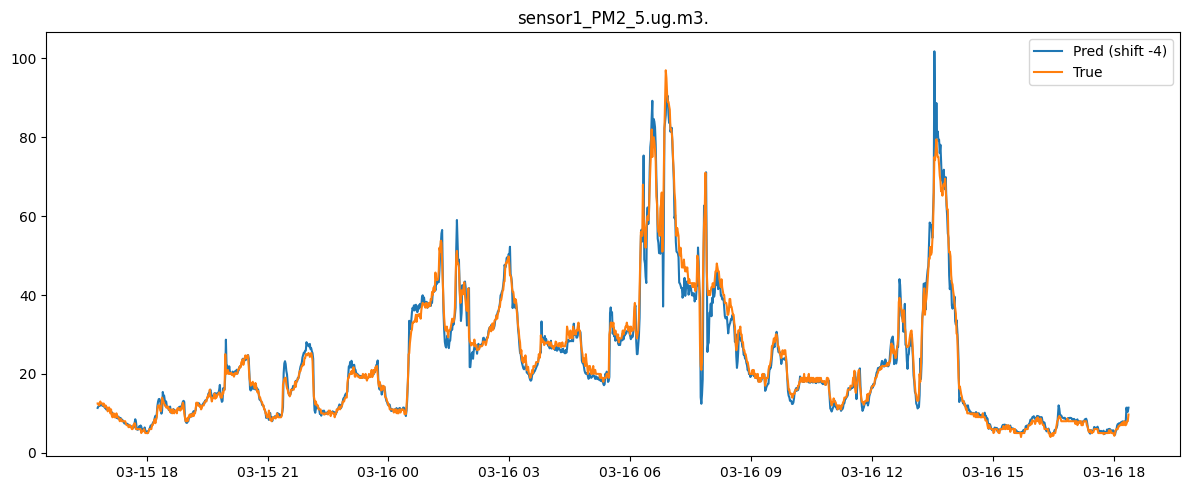


sensor1_PM2_5.ug.m3. -> MAE:1.5421, RMSE:2.7151, R²:0.9719, MAPE:6.75% (shift=-4)
{'sensor1_PM2_5.ug.m3.': {'MAE': 1.5421017133075414, 'RMSE': np.float64(2.7151147175078543), 'R2': 0.9718608544060603, 'MAPE': 6.7472784212994625, 'shift': -4}}


In [11]:
if __name__ == "__main__":
    train_time   = 335
    test_time    = 30
    pred_pos     = 70
    stride       = 15
    start, end   = 0.8, 1.0
    variables    = ['PM2_5.ug.m3.']
    base_path    = '/content/1_mins/'
    all_sensors  = {
        'sensor1': f'{base_path}01_01mins.csv',
        'sensor2': f'{base_path}02_01mins.csv',
        'sensor3': f'{base_path}03_01mins.csv',
        'sensor4': f'{base_path}04_01mins.csv',
    }

    data_all, names_all, time_index = load_and_align_data(all_sensors, variables)

    data_in  = [data_all[i] for i in [1, 2, 3]]
    data_out = [data_all[0]]

    pred_y, true_y, model, scaling = SP_Learner_3to1(
        data_in, data_out,
        train_time, test_time, pred_pos, stride, start, end
    )

    # pred_y có shape = (n_windows, test_time, 1)
    preds = pred_y[:, :, 0]
    print("=== Các giá trị dự đoán cho sensor1 ===")
    print(preds)

    import pandas as pd

    col_names = [f"step_{i+1}" for i in range(preds.shape[1])]
    df_preds = pd.DataFrame(preds, columns=col_names)

    df_preds.index.name = "window_idx"

    out_csv = "predictions_sensor1(15mins).csv"
    df_preds.to_csv(out_csv, index=True)
    print(f"Đã lưu dự đoán vào file: {out_csv}")

    res = evaluate_model(
        pred_y, true_y,
        ['sensor1_' + variables[0]],
        scaling, time_index, start
    )
    print(res)
